![](https://ph-files.imgix.net/b16e18a0-1338-4adc-b31f-0f0883c88ad5?auto=format&auto=compress&codec=mozjpeg&cs=strip)

In [1]:
import numpy as np
import pandas as pd
import os
from time import time
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
import pickle

import keras
from keras.regularizers import l1, l2
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
%matplotlib inline

Using TensorFlow backend.


----

### Introduction 

In this notebook, we quickly implement a solution to classifying physical activities that is very similar to the solution presented in this paper [Exercise Motion Classification from Large-Scale Wearable Sensor Data
Using Convolutional Neural Networks](https://arxiv.org/pdf/1610.07031.pdf). Just as the data in the paper, the data set used in this notebook was collected from sensors that are attached to people while they perform their physical activities. 

The solution in this notebook has some differences. 

First of all, the data set used here is for general activities such as walking up and down a flight of stairs, running on a treadmil, laying down, and sitting. The data set in the paper exclusively contains weightroom activities, such as bench pressing and squats. 

Second, unlike the dataset in the paper, the data used in this notebook is relatively clean. So things like zero-padding the sensor data is not necessary here. 

Thrid, unlike the dataset in the paper, there are no reps or sets in data set used in this notebook. 

The value of this work is to demonstrate that the approach to using Convolutional Neural Networks (CNNs) to classify time series data is an effective general solution that can be potentially be used for BioStrap's data.  

This notebook doesn't contain any indepth analysis of the dataset (which is not it's goal), it instead focuses on training a CNN. For those interested in data analysis, feel free to check out this [Jupyter Notebook](https://github.com/DataBeast03/DataBeast/blob/master/MachineLearning/Data_Scienec_Case_Study_IoT.ipynb).

Change.

----

### Load and Format Data

In [2]:
# these functions are used to load the data from the hierarchy of folders in which it is stored

def generate_feature_names():
    '''Creates feature names for dataframe header'''
    feat_names = []
    for unit_label in ["T", "RA", "LA", "RL", "LL"]:
        for sensor  in ["acc","gyro","mag"]:
            for position in ['X','Y','Z']:
                feat_names.append(unit_label + "_" + position + sensor)
    return feat_names

def get_activity_files_names():
    '''Creates activity file names'''
    activity_files = []
    for num in np.arange(1,20,1):
        if num < 10:
            activity_files.append("a0{}".format(num))
        else:
            activity_files.append("a{}".format(num))
    return activity_files

def get_segment_files_names():
    '''Creates segment file names'''
    segment_files = []
    for num in np.arange(1,61,1):
        if num < 10:
            segment_files.append("s0{}.txt".format(num))
        else:
            segment_files.append("s{}.txt".format(num))
    return segment_files

def get_data(data_home, feat_names, body_part, activity_files, person_files, segment_files):
    '''loads data, extracts features, and transforms data'''
    player_data = defaultdict(list)
    # for activity_i
    for act_i, activity in enumerate(activity_files):
        act_i += 1
        # for person_j
        for per_i, person in enumerate(person_files):
            per_i += 1
            # for segment_k
            for seg_i, segment in enumerate(segment_files): 
                seg_i += 1
                
                # load segment data
                segment_path = data_home + activity + "/" + person + "/" + segment
                
                # put data in dataframe
                df = pd.read_csv(segment_path, header=None)
                
                # assign column names
                df.columns = feat_names
                df = df[body_part].copy()
                
                # each segment is now a row 
                player_data[act_i].append(df)   
                
    return player_data

In [3]:
# generate names of activities and segments to create file names
activity_files = get_activity_files_names()
segment_files =  get_segment_files_names()
person_files = ["p{}".format(num) for num in np.arange(1,9,1)]

In [4]:
data_home = "/Users/Alexander/IPython_Notebooks/CNN_Activity_Classification/data/"
feat_names = generate_feature_names()
right_arm = feat_names[9:18]

In [5]:
# extract revelent data
start = time()
player_data = get_data(data_home,
                       feat_names, 
                       right_arm, 
                       activity_files, 
                       person_files, 
                       segment_files)
end = time()
print (end - start)

68.99085593223572


In [6]:
# keys in the dict are the activity numbers
player_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [7]:
# this many 2D samples for each activity 
len(player_data[1])

480

In [8]:
# fortunately for us, we won't have to zero-pad our samples 
# due to the way that the data was measured 

# the shape of each sample
# 25 Hz --> 25 samples per second 
# 5 second samples
# 25 * 5 = 125 samples (rows)
# 9 features --> 3 dims for each of the 3 devices
player_data[1][1].shape

(125, 9)

In [9]:
# the right arm readings of each activity 
player_data[1][1].head()

,RA_Xacc,RA_Yacc,RA_Zacc,RA_Xgyro,RA_Ygyro,RA_Zgyro,RA_Xmag,RA_Ymag,RA_Zmag
0,0.62906,5.7852,7.8624,0.023668,0.003574,-0.008247,-0.56515,-0.56762,-0.20656
1,0.59229,5.8239,7.8745,0.027182,0.000057,-0.004739,-0.56430,-0.56565,-0.20720
2,0.60946,5.8190,7.8795,0.002920,-0.003381,0.002559,-0.56486,-0.56409,-0.20765
3,0.61184,5.8095,7.8551,-0.004387,-0.019235,0.006979,-0.53649,-0.55611,-0.18054
4,0.65361,5.7851,7.8796,0.009090,-0.010397,0.008698,-0.56850,-0.56411,-0.20785


In [10]:
acc_cols = ["RA_Xacc","RA_Yacc", "RA_Zacc"]
gyro_cols = ["RA_Xgyro","RA_Ygyro", "RA_Zgyro"]
mag_cols = ["RA_Xmag","RA_Ymag", "RA_Zmag"]

# the paper says to think of each device has a RBG color channel 
R = player_data[1][1][acc_cols].values
B = player_data[1][1][gyro_cols].values
G = player_data[1][1][mag_cols].values

In [11]:
# notice how the top 2D array is contains the acceleration values 
rbg_sample = np.array((R,B,G))
print(rbg_sample.shape)
rbg_sample

(3, 125, 3)


array([[[  6.29060000e-01,   5.78520000e+00,   7.86240000e+00],
        [  5.92290000e-01,   5.82390000e+00,   7.87450000e+00],
        [  6.09460000e-01,   5.81900000e+00,   7.87950000e+00],
        ..., 
        [  6.35990000e-01,   5.83370000e+00,   7.83620000e+00],
        [  6.14080000e-01,   5.82870000e+00,   7.86280000e+00],
        [  6.24020000e-01,   5.80440000e+00,   7.88460000e+00]],

       [[  2.36680000e-02,   3.57400000e-03,  -8.24700000e-03],
        [  2.71820000e-02,   5.70000000e-05,  -4.73900000e-03],
        [  2.92000000e-03,  -3.38100000e-03,   2.55900000e-03],
        ..., 
        [  1.64980000e-02,   9.14000000e-04,  -1.42670000e-02],
        [ -1.60700000e-03,  -5.11100000e-03,   2.74100000e-03],
        [  1.37250000e-02,   7.21400000e-03,   1.20000000e-05]],

       [[ -5.65150000e-01,  -5.67620000e-01,  -2.06560000e-01],
        [ -5.64300000e-01,  -5.65650000e-01,  -2.07200000e-01],
        [ -5.64860000e-01,  -5.64090000e-01,  -2.07650000e-01],
        

In [12]:
def reformate_data(player_data, acc, gyro, mag):
    '''Reformats the dims of the data'''
    X_data = []
    Y_data = []
    for activty, data_list in player_data.items():
        for df in data_list:
            
            acc = df[acc_cols].values
            gyro = df[gyro_cols].values
            mag = df[mag_cols].values

            formated_sample = np.array((acc,gyro,mag))

            X_data.append(formated_sample)
            Y_data.append(activty)

    return np.array(X_data), np.array(Y_data)

In [13]:
start = time()
X_data, Y_data = reformate_data(player_data, 
                                acc_cols, 
                                gyro_cols, 
                                mag_cols)
end = time()
print (end - start)

17.51854109764099


In [14]:
Y_data.shape

(9120,)

In [15]:
num_classes = len(np.unique(Y_data))

In [16]:
# (samples, channels, rows, cols)
X_data.shape

(9120, 3, 125, 3)

In [17]:
Y_data = Y_data.reshape((Y_data.shape[0],1))

In [18]:
# labels must be one-hot encoded for the softmax layer of the CNN
encoder = OneHotEncoder()
encoder.fit(Y_data)  

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [19]:
Y_data = encoder.transform(Y_data).toarray()

In [20]:
X_data, Y_data = shuffle(X_data, Y_data)

In [21]:
save_data = "model_ready_data.pkl"
pickle.dump((X_data, Y_data), open(save_data, 'wb'))

In [22]:
# save_data = "model_ready_data.pkl"
# X_data, Y_data = pickle.load(open(save_data, 'rb'))

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.20, random_state = 1234)

------


### Train CNN

Here we will build and train our CNN. We will follow the paper in selection two convolutional layers with max pooling. But instead of using a single fully connected layer, we'll use two. 

Also, the paper used TensorFlow to build their model. TensorFlow is a great package to use for building deep learning models, however it requires a lot of boilerplate code. The beauty of Keras is that it is a wrapper around TensorFlow that takes care of that boilerplate code for you. Which allows for much quicker iterations. 

In [24]:
# CNN model
model = Sequential()


model.add(Conv2D(filters=32, 
                 kernel_size=(1, 1), 
                 strides=(1, 1),
                 activation='relu',
                 input_shape=(3, 125, 3)))

model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(1, 1)))

model.add(Conv2D(filters=64, 
                 kernel_size=(1, 1), 
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [25]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [26]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

In [27]:
history = AccuracyHistory()

In [28]:
model.fit(X_train, Y_train,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history])

Train on 7296 samples, validate on 1824 samples
Epoch 1/10
7296/7296 [==============================] - 17s - loss: 1.8526 - acc: 0.3982 - val_loss: 1.4093 - val_acc: 0.4890
Epoch 2/10
7296/7296 [==============================] - 17s - loss: 1.1362 - acc: 0.6235 - val_loss: 1.0706 - val_acc: 0.6447
Epoch 3/10
7296/7296 [==============================] - 17s - loss: 0.8063 - acc: 0.7503 - val_loss: 0.7545 - val_acc: 0.7955
Epoch 4/10
7296/7296 [==============================] - 17s - loss: 0.6159 - acc: 0.8096 - val_loss: 0.6204 - val_acc: 0.8196
Epoch 5/10
7296/7296 [==============================] - 17s - loss: 0.4884 - acc: 0.8509 - val_loss: 0.6359 - val_acc: 0.7791
Epoch 6/10
7296/7296 [==============================] - 17s - loss: 0.3891 - acc: 0.8853 - val_loss: 0.4708 - val_acc: 0.8646
Epoch 7/10
7296/7296 [==============================] - 17s - loss: 0.3221 - acc: 0.9057 - val_loss: 0.4189 - val_acc: 0.8723
Epoch 8/10
7296/7296 [==============================] - 17s - loss: 0.

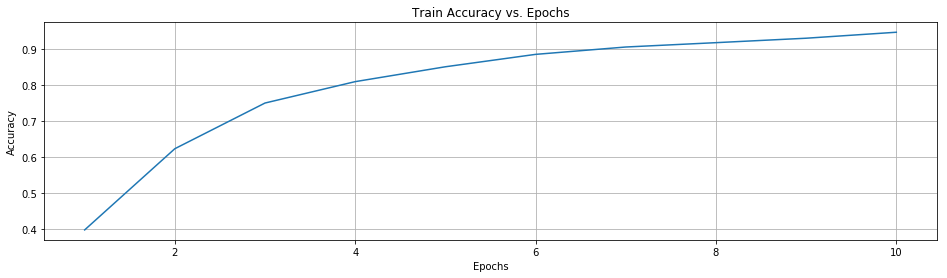

In [29]:
plt.figure(figsize= (16,4))
plt.grid()
plt.plot(range(1,11), history.acc)
plt.title("Train Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Observations

The plot above shows the Accuracy score for the train set after each epoch of training. We can see that the performance monotonically increases with each epoch. More importantly, we can see from the model's training output that the test scores are also monotonically increasing. The plot suggest that the model's perforance would increase with more traininng samples. 

Note that the CNN model has not been optimzed. It's likely that the performance would go up with optimized hyperparameters. Also it would be worth while to explore with different architectures. The authers of the paper stated that a 3-layer CNN performed the best. 
